　「RとStanで始めるベイズ統計モデリングによるデータ分析入門」「実践編第5部第6章 周期性のモデル化」を対象に，公開されているR，Stanのコードをpython，pystanのコードへと書き直した一例です。Stanの代わりにpystanを利用しています。
 
 　この章では，基本構造時系列モデルという動的線形モデルを用いて，周期的な変動を示す時系列データを分析する問題を扱っています。

　本ページでは公開されていない書籍の内容については一切触れません。理論や詳しい説明は書籍を参照してください。

　なお，こちらで紹介しているコードには誤りが含まれる可能性があります。内容やコードについてお気づきの点等ございましたら，ご指摘いただけると幸いです

# 分析の準備

## パッケージの読み込み

In [24]:
import arviz
import pystan
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Meiryo'

# 状態空間モデルの図示をする関数の読み込み
from plotSSM import plotSSM

## データの読み込みと図示
### データの読み込み

In [4]:
sales_df_4 = pd.read_csv('5-6-1-sales-ts-4.csv')
sales_df_4['date'] = pd.to_datetime(sales_df_4['date']) # datetime型へ変換
sales_df_4.head(n=3)

,date,sales
0,2010-01-01,81.1
1,2010-01-02,127.7
2,2010-01-03,119.5


### 図示

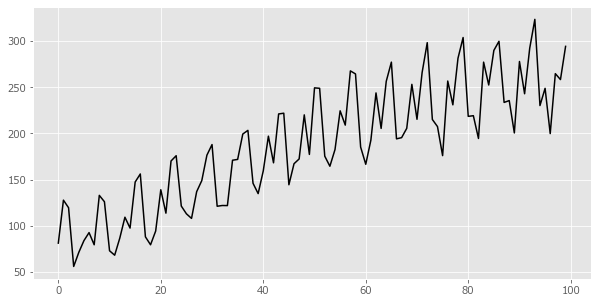

In [7]:
plt.figure(figsize=(10,5))
plt.plot(sales_df_4['sales'], color='black')
plt.show()

# 基本構造時系列モデルの推定
## データの準備

In [8]:
data_list = dict(y=sales_df_4['sales'], 
                 T=len(sales_df_4))

## 基本構造時系列モデルの推定

　samplingの引数'control'に関して，Rではリスト形式で指定をしますが，pystanではdictionary形式で指定をします。

In [15]:
# stanコードの記述（5-6-1-basic-structual-time-series.stan）
stan_code = '''
data {
  int T;        // データ取得期間の長さ
  vector[T] y;  // 観測値
}

parameters {
  vector[T] mu;       // 水準+ドリフト成分の推定値
  vector[T] gamma;    // 季節成分の推定値
  real<lower=0> s_z;  // ドリフト成分の変動の大きさを表す標準偏差
  real<lower=0> s_v;  // 観測誤差の標準偏差
  real<lower=0> s_s;  // 季節変動の大きさを表す標準偏差
}

transformed parameters {
  vector[T] alpha;        // 各成分の和として得られる状態推定値
  
  for(i in 1:T) {
    alpha[i] = mu[i] + gamma[i];
  }

}

model {
  // 水準+ドリフト成分
  for(i in 3:T) {
    mu[i] ~ normal(2 * mu[i-1] - mu[i-2], s_z);
  }
  
  // 季節成分
  for(i in 7:T){
    gamma[i] ~ normal(-sum(gamma[(i-6):(i-1)]), s_s);
  }
  
  // 観測方程式に従い、観測値が得られる
  for(i in 1:T) {
    y[i] ~ normal(alpha[i], s_v);
  }

}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
basic_structual = stan_model.sampling(data=data_list,
                                      seed=1,
                                      iter=8000,
                                      warmup=2000,
                                      thin=6,
                                      control={
                                          'adapt_delta': 0.97,
                                          'max_treedepth': 15
                                      },
                                      n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_88aecf111a22f117e1ef8a496e57ea25 NOW.


## 基本構造時系列モデルの推定結果

In [16]:
print(
    basic_structual.stansummary(pars=["s_z", "s_s", "s_v", "lp__"],
                                probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_88aecf111a22f117e1ef8a496e57ea25.
4 chains, each with iter=8000; warmup=2000; thin=6; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
s_z    0.24  6.2e-3   0.12    0.1   0.21   0.55    361   1.01
s_s    4.22    0.02   0.94   2.57   4.15   6.19   1985    1.0
s_v    7.39    0.02   0.99   5.52   7.35   9.45   2893    1.0
lp__ -326.4    2.25  43.23 -415.9 -324.4 -247.2    371   1.01

Samples were drawn using NUTS at Sun Sep 13 03:08:53 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## 参考：収束の確認

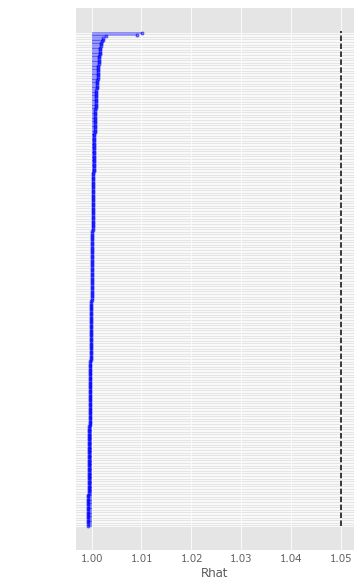

In [18]:
# 収束確認用のRhatのプロット関数
def mcmc_rhat(dataframe, column='Rhat', figsize=(5, 10)):
    plt.figure(figsize=figsize)
    plt.hlines(y=dataframe[column].sort_values().index,
               xmin=1,
               xmax=dataframe[column].sort_values(),
               color='b',
               alpha=0.5)
    plt.vlines(x=1.05, ymin=0, ymax=len(dataframe[column]), linestyles='--')
    plt.plot(dataframe[column].sort_values().values,
             dataframe[column].sort_values().index,
             marker='.',
             linestyle='None',
             color='b',
             alpha=0.5)
    plt.yticks(color='None')
    plt.tick_params(length=0)
    plt.xlabel(column)
    plt.show()


# 各推定結果のデータフレームを作成
summary = pd.DataFrame(basic_structual.summary()['summary'],
                       columns=basic_structual.summary()['summary_colnames'],
                       index=basic_structual.summary()['summary_rownames'])

# プロット
mcmc_rhat(summary)

In [19]:
print('hmc_diagnostics of local_level:\n',
      pystan.diagnostics.check_hmc_diagnostics(basic_structual))

hmc_diagnostics of local_level:
 {'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


## 参考：トレースプロット

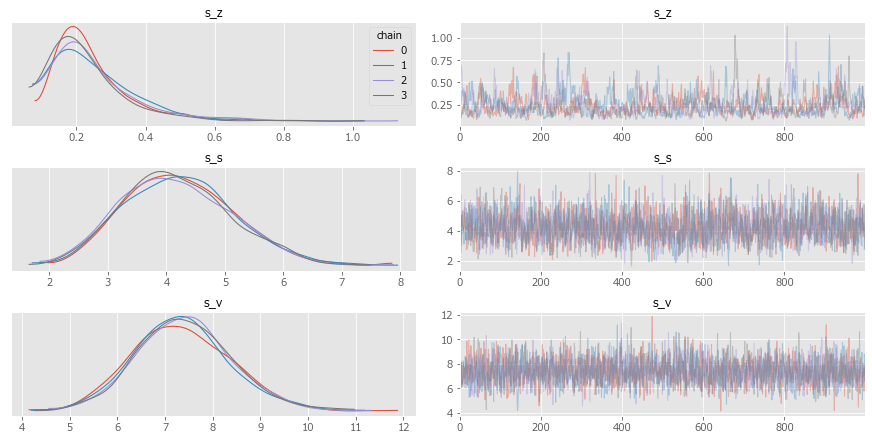

In [22]:
mcmc_sample = basic_structual.extract()
arviz.plot_trace(basic_structual,
                 var_names=["s_z", "s_s", "s_v"],
                 legend=True);

## 参考：推定結果一覧

In [23]:
print(basic_structual.stansummary(probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_88aecf111a22f117e1ef8a496e57ea25.
4 chains, each with iter=8000; warmup=2000; thin=6; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mu[1]       82.57     0.1   3.96  75.23  82.41  90.49   1714    1.0
mu[2]       84.13    0.08   3.45  77.65  84.05  91.06   1864    1.0
mu[3]       85.71    0.07   3.01  79.95  85.69   91.8   2134    1.0
mu[4]       87.29    0.05   2.66  82.17  87.27  92.62   2467    1.0
mu[5]       88.89    0.04   2.38  84.31  88.89  93.56   2826    1.0
mu[6]       90.51    0.04   2.18  86.26   90.5  94.85   3226    1.0
mu[7]       92.15    0.04   2.06  87.98  92.16  96.21   3356    1.0
mu[8]       93.84    0.04   2.01  89.85  93.86  97.82   3245    1.0
mu[9]       95.61    0.04    2.0  91.51  95.65  99.52   2840    1.0
mu[10]      97.46    0.04   2.02  93.37   97.5 101.33   2215    1.0
mu[11]      99.38    0.05   2.05  95.26  99.44 103.25   1892   

# 推定結果の図示

## MCMCサンプルの取得

In [26]:
mcmc_sample = basic_structual.extract()

## すべての成分を含んだ状態推定値の図示

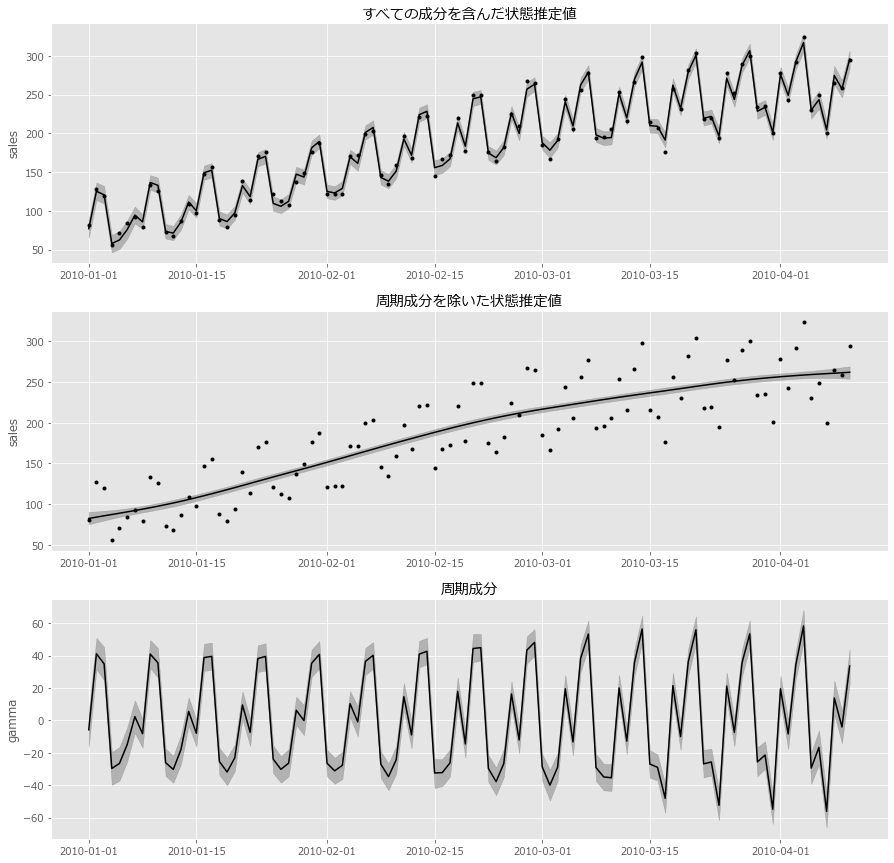

In [30]:
# グラフ描画領域の作成
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# plotSSM関数によるグラフ作成
p_all = plotSSM(mcmc_sample,
                time_vec=sales_df_4['date'],
                obs_vec = sales_df_4['sales'],
                state_name="alpha",
                graph_title='すべての成分を含んだ状態推定値',
                y_label='sales',
                axes=ax[0])

p_all = plotSSM(mcmc_sample,
                time_vec=sales_df_4['date'],
                obs_vec = sales_df_4['sales'],
                state_name="mu",
                graph_title='周期成分を除いた状態推定値',
                y_label='sales',
                axes=ax[1])

p_all = plotSSM(mcmc_sample,
                time_vec=sales_df_4['date'],
                state_name="gamma",
                graph_title='周期成分',
                y_label='gamma',
                axes=ax[2])

plt.show()